In [1]:
import sys, os

import matplotlib.pyplot as plt
from matplotlib import rcParams

import numpy as np
import torch
from torch import nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import (SVI, Trace_ELBO, TraceMeanField_ELBO,
                        MCMC, NUTS, Predictive
                       )

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
N_WORKERS = 4 if os.name != 'nt' else 0
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    DEVICE = torch.device('cpu')
    IS_CUDA = False
    
print("Device:", DEVICE)
rcParams.update({'font.size': 12})
if '..' not in sys.path:
    sys.path.append('..')

Device: cuda


In [4]:
%load_ext autoreload
%autoreload 1

%aimport bnn_vi.plotting
# %aimport bnn_vi.plotting, bnn_vi.models

# from bnn_vi.models import (Multilayer,
#                            MultilayerBayesian,
#                            MultilayerBayesianTrick,
#                            ModelGenerator,
#                            EstimatorPool
# )
from bnn_vi.plotting import (ProgressPlotter,
                             plot_1D
)

# np.random.seed(0)
# torch.manual_seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# pyro.set_rng_seed(0)

In [5]:
a = torch.ones(2, 1, 5, 5)
with pyro.plate_stack("plate_stack", a.shape) as ind:
#     print(ind)
    d = dist.Normal(0, 1)
    print(d.shape())
    x = pyro.sample("x", d)
    print(x.shape) 

torch.Size([])
torch.Size([2, 1, 5, 5])


In [6]:
# https://pyro.ai/examples/vae.html

class VAE(nn.Module):
    def __init__(self, encoder, decoder, hidden_dim, device=torch.device('cpu'), 
                 target_std=0.1):
        super().__init__()
        self.device  = device
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.z_dim = hidden_dim
        self.target_std = target_std

    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
    
        # x.new_zeros allows to create the parameters on the right device
        with pyro.plate_stack("code_plates", (x.shape[0], self.z_dim)):
            z = pyro.sample("latent", dist.Normal(x.new_zeros(1), 1.))
        
        # decode the latent code z
        loc_img = self.decoder.forward(z)
        
        with pyro.plate_stack("data_plates", x.shape):
            pyro.sample("obs", dist.Normal(x, self.target_std), obs=loc_img)
        
        return loc_img
        
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        
        # use the encoder to get the parameters used to define q(z|x)
        z = self.encoder.forward(x)
        middle = z.shape[-1]//2
        z_loc, z_scale = z[:, :middle], torch.exp(z[:, middle:])
        
        with pyro.plate_stack("code_plates", (x.shape[0], self.z_dim)):
            pyro.sample("latent", dist.Normal(z_loc, z_scale))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z = self.encoder.forward(x)
        middle = z.shape[-1]//2
        z_loc, z_scale = z[:, :middle], torch.exp(z[:, middle:])
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

    def train(self, data_loader, n_epochs, num_particles=1, lr=1e-3,
              log_per=5, show_smooth=True, save_per=10):

        pyro.clear_param_store()

        optimizer = pyro.optim.Adam({"lr": lr})
        svi = SVI(self.model, self.guide, optimizer, 
                  Trace_ELBO(num_particles=num_particles,
                             vectorize_particles=True))
        losses = []

        fig = None
        pp = ProgressPlotter(losses, "$-ELBO$", log_per, show_smooth)
        pp.start()
        for epoch in range(n_epochs):
            total_loss = 0.
            for x, _ in data_loader:
                x = x.to(self.device)
                loss = svi.step(x) / x.numel()
                total_loss += loss
            total_loss /= len(data_loader)
            losses.append(total_loss)
            fig = pp.update(epoch)
            if epoch % save_per == 1:
                self.save('VAE.pth')
        return pp.fig, losses
    
    def get_mean_std(self, x, n_repeats=50):
        predictive = Predictive(self.model, guide=self.guide, num_samples=n_repeats,
                                return_sites=("_RETURN", ))
        x = x.to(self.device)
        z = predictive(x)['_RETURN']
        return z.mean(dim=0), z.std(dim=0)

    def save(self, filename):
        state = {'state_dict': self.state_dict(),
                 'params': pyro.get_param_store().get_state()
                }
        torch.save(state, filename)

    def load(self, filename):
        state = torch.load(filename)
        self.load_state_dict(state['state_dict'])
        self.guide = state['guide']
        pyro.get_param_store().set_state(state['params']) 

In [7]:
def count_parameters(model, filter=lambda x: x.requires_grad):
    return sum(list(p.numel() for p in model.parameters() if filter(p)))

def conv_shape(h, kernel_size=1, stride=1, pad=0):
    w = np.floor(((h + (2 * pad) - (kernel_size - 1) - 1) / stride) + 1)
    return int(w)

def transpose_shape(h, kernel_size=1, stride=1, pad=0):
    w = (h - 1) * stride - 2 * pad + kernel_size
    return int(w)

class Reshape(nn.Module):
    def __init__(self, *shape, preserve=None, mode='right'):
        """
        The preserve parameter indicates the position of right-most 
        (left-most, see mode) dimension that will not be affected by the
        reshape. For example, preserve = -1 (preserve = 0) will
        just append (prepend) the shape to the shape of input. 
        
        Mode specifies whether the new shape should be appended 
        ('right') or prepended ('left').
        
        If preserve is None, all the dimensions should be specified
        explicitly.
        """
        super().__init__()
        self.preserve = preserve
        self.mode = mode
        self.shape = torch.Size(shape)
        
    def forward(self, input):
        if self.preserve == None:
            return input.reshape(self.shape)
        
        old_shape = input.shape 
        new_shape = None
        idx = None
        if self.preserve < 0:
            n_dims = len(old_shape)
            idx = n_dims+1+self.preserve
        else:
            idx = self.preserve
            
        if self.mode == 'right':
            left = old_shape[:idx]
            new_shape = left + self.shape
        elif self.mode == 'left':
            right = old_shape[idx:]
            new_shape = self.shape + right
        else:
            raise ValueError(f"Invalid mode: should be 'right' or 'left', but given {self.mode}")
        
        return input.reshape(new_shape)
    
class Debugger(nn.Module):
    def __init__(self, name=""):
        super().__init__()
        self.name = name
        
    def forward(self, input):
        print(self.name, input.shape)
        return input

In [8]:
HIDDEN_DIM = 30
TARGET_STD = 0.1
BATCH_SIZE = 256
NUM_PARTICLES = 32

In [9]:
n_ch = 16
kernel_size = 3
half_kernel = kernel_size//2
encoder = nn.Sequential(nn.BatchNorm2d(1),
                        nn.Conv2d(1, n_ch, kernel_size, stride=2, padding=half_kernel), # 28 -> 14
                        nn.ReLU(),
                        nn.BatchNorm2d(n_ch),
                        nn.Conv2d(n_ch, n_ch*2, kernel_size, stride=2, padding=half_kernel), # 14 -> 7
                        nn.ReLU(),
                        nn.BatchNorm2d(n_ch*2),
                        nn.Conv2d(n_ch*2, n_ch*4, kernel_size, stride=2, padding=half_kernel),  # 7 -> 4
                        nn.ReLU(),
                        nn.AdaptiveMaxPool2d(1),
                        Reshape(preserve=-3),
                        nn.Linear(n_ch*4, 2*HIDDEN_DIM)
                       )

decoder = nn.Sequential(Reshape(-1, preserve=-2, mode='left'), # Packing vectorized particles
                        nn.Linear(HIDDEN_DIM, n_ch*4),
                        Reshape(1, 1, preserve=-1),
                        nn.ConvTranspose2d(n_ch*4, n_ch*4, 4, groups=n_ch*4),
                        nn.BatchNorm2d(n_ch*4),
                        nn.ConvTranspose2d(n_ch*4, n_ch*2, kernel_size,
                                           stride=2, padding=half_kernel),
                        nn.ReLU(),
                        nn.BatchNorm2d(n_ch*2),
                        nn.ConvTranspose2d(n_ch*2, n_ch, kernel_size,
                                           stride=2, padding=half_kernel),
                        nn.ReLU(),
                        nn.BatchNorm2d(n_ch),
                        nn.ConvTranspose2d(n_ch, 1, kernel_size,
                                           stride=2, padding=half_kernel),
                        nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False),
                        nn.Sigmoid(),
                        Reshape(NUM_PARTICLES, 1, 1, -1, preserve=-4, mode='left'), # Unacking vectorized particles
)

In [10]:
data = MNIST('../data/mnist', download=True, transform=transforms.ToTensor(),
                    train=False)

data_loader = DataLoader(data, #Subset(data, torch.arange(100)), 
                         batch_size=BATCH_SIZE, shuffle=True,
                         pin_memory=IS_CUDA)

In [11]:
model = VAE(encoder, decoder, HIDDEN_DIM, device=DEVICE, target_std=TARGET_STD)

In [12]:
N_EPOCHS = 20
LOG_PER = 1

LR = 1e-3

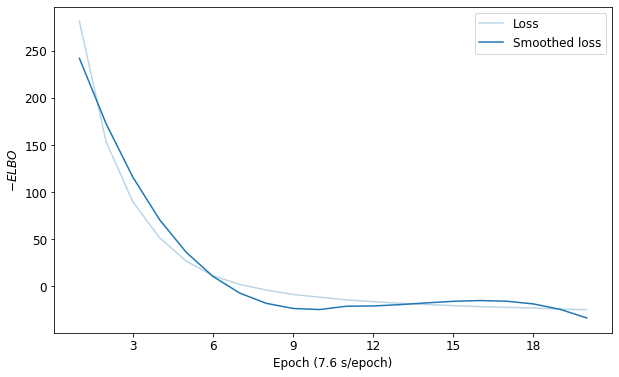

(<Figure size 720x432 with 1 Axes>,
 [281.1045024827446,
  153.44419680408063,
  89.80971496579596,
  51.78298189080491,
  26.81370616907976,
  11.492066107964025,
  2.143219007521259,
  -3.817998447223585,
  -8.470276357932967,
  -11.429524612183474,
  -14.288450642264621,
  -16.110760556191813,
  -17.87057219086861,
  -19.2405307999679,
  -20.36194907147057,
  -21.445277800487013,
  -22.16466532373915,
  -22.862657769723814,
  -24.071973782899427,
  -24.616305024891485])

In [13]:
import logging
logging.basicConfig(level=logging.INFO)

model.train(data_loader, N_EPOCHS, num_particles=NUM_PARTICLES, lr=LR,
            log_per=LOG_PER, show_smooth=True, save_per=LOG_PER*10)

RuntimeError: shape '[32, 1, 1, -1, 1, 28, 28]' is invalid for input of size 784
      Trace Shapes:            
       Param Sites:            
 decoder$$$1.weight       64 30
   decoder$$$1.bias          64
 decoder$$$3.weight 64  1  4  4
   decoder$$$3.bias          64
 decoder$$$4.weight          64
   decoder$$$4.bias          64
 decoder$$$5.weight 64 32  3  3
   decoder$$$5.bias          32
 decoder$$$7.weight          32
   decoder$$$7.bias          32
 decoder$$$8.weight 32 16  3  3
   decoder$$$8.bias          16
decoder$$$10.weight          16
  decoder$$$10.bias          16
decoder$$$11.weight 16  1  3  3
  decoder$$$11.bias           1
      Sample Sites:            
 code_plates_0 dist           |
              value       30  |
 code_plates_1 dist           |
              value        1  |
        latent dist     1 30  |
              value     1 30  |

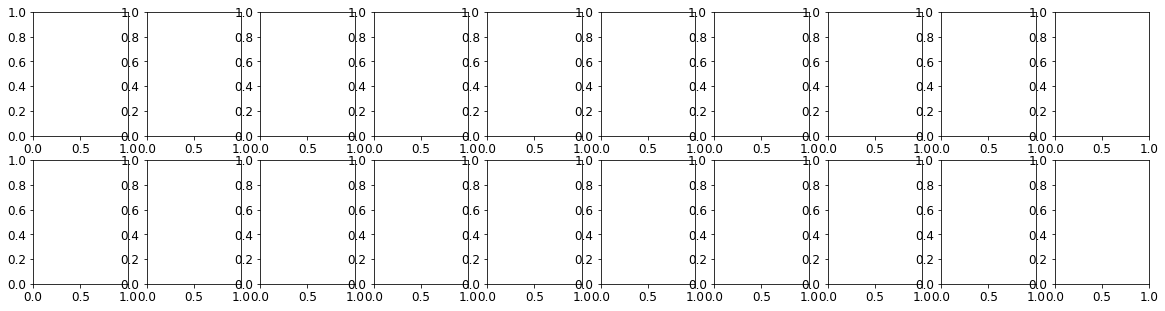

In [16]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    im = data[i][0]
    with torch.no_grad():
        mean, _ = model.get_mean_std(im.unsqueeze(0).to(DEVICE))
        rec = mean.to("cpu").detach()
    ax[0, i].imshow(im[0].reshape(28,28));
    ax[1, i].imshow(rec.reshape(28,28));
    ax[0, i].axis('off')
    ax[1, i].axis('off')